In [1]:
import numpy as np
import scipy
import matplotlib as mpl
from matplotlib import pyplot as plt
import torch
import torchvision
from torch import nn, optim
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.io import loadmat
import os, sys
import torchvision.transforms as transforms
import string
from  collections import defaultdict
from sklearn.linear_model import LassoCV

# images = loadmat('baoimg.mat').get('img')
%run training_code/clean_cornets.py

In [2]:
from torchvision import datasets, transforms

# data_dir = 'images/'
data_dir = 'stimuli/wordselective_stimuli_bao/'
transform = {'train': transforms.Compose([transforms.Resize((224,224)),
transforms.ToTensor(),
transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]),}

chosen_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), transform =  transform[x]) for x in ['train']}
dataloaders = {x: torch.utils.data.DataLoader(chosen_datasets[x], batch_size = 80,shuffle = False) for x in ['train']}


In [3]:
dataiter = iter(dataloaders['train'])

nBli = {}; nBli['v1'] = []; nBli['v2'] = []; nBli['v4'] = [];
nBli['it'] = []; nBli['h'] = []; nBli['out'] = []

# net = CORNet_Z_nonbiased_words()
# checkpoint = torch.load('models/save_lit_no_bias_z_79_full_nomir.pth.tar')['state_dict']
net = CORnet_Z_tweak()
checkpoint = torch.load('models/save_illit_z_79_full_nomir.pth.tar')['state_dict']
for key in list(checkpoint.keys()):
    if 'module.' in key:
        checkpoint[key.replace('module.', '')] = checkpoint[key]
        del checkpoint[key]
net.load_state_dict(checkpoint)
# net.eval() 
    
for i in range(3):
    stimtemp, classes = next(dataiter)
    # nBli['v1'], nBli['v2'], nBli['v4'], nBli['it'], nBli['h'],  nBli['out'] = net(stimtemp.float())
    varV1, varV2, varV4, varIt, varh, varOut = net(stimtemp.float())
    nBli['v1'].extend(varV1.detach().numpy())
    nBli['v2'].extend(varV2.detach().numpy())
    nBli['v4'].extend(varV4.detach().numpy())
    nBli['it'].extend(varIt.detach().numpy())
    nBli['h'].extend(varh.detach().numpy())
    nBli['out'].extend(varOut.detach().numpy())
    print(i)


0
1
2


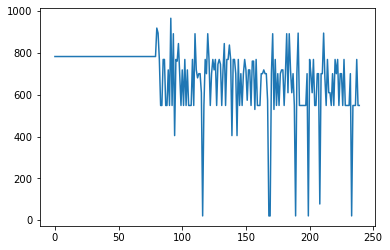

In [4]:
plt.plot(np.argmax(nBli['out'],1))

In [6]:
# Identify word selective units based on 3 standard deviations above the mean
qo = np.array(np.arange(0,80)); 
qe = np.array(np.arange(80,160)); 
qc = np.array(np.arange(160,240)); 
data_d = np.array(nBli['h'])

neuid_c = []; neuid_e = [];
for unit in range(np.size(data_d,1)):
    Enmean = np.mean(data_d[qe,unit])
    Chmean = np.mean(data_d[qc,unit])
    Objmean   = np.mean(data_d[qo,unit])
    Objstdev  = np.var(data_d[qo,unit])**0.5

    if Enmean >= Objmean + 3*Objstdev:
        neuid_e.append(unit)

    if Chmean >= Objmean + 3*Objstdev:
        neuid_c.append(unit)
        
neuid_ec = np.intersect1d(neuid_c,neuid_e)
print(['% of English word-selective units: ' + str(np.size(neuid_e)/np.size(data_d,1)) + ', count: ' + str(np.size(neuid_e))])
print(['% of Chinese word-selective units: '+ str(np.size(neuid_c)/np.size(data_d,1)) + ', count: ' + str(np.size(neuid_c))])
print(['% of English-chinese word-selective units: ' + str(np.size(neuid_ec)/np.size(data_d,1)) + ', count: ' + str(np.size(neuid_ec))])


['% of English word-selective units: 0.587890625, count: 301']
['% of Chinese word-selective units: 0.58984375, count: 302']
['% of English-chinese word-selective units: 0.580078125, count: 297']


In [ ]:
# Identify word selective units based on statistical test
from scipy.stats import spearmanr

qo = np.array(np.arange(0,400)); 
qf = np.array(np.arange(400,800)); 
qc = np.array(np.arange(800,1200));  
data_d = np.array(nBli['h'])

Fpval = []; Cpval = [];
for unit in range(np.size(data_d,1)):
    Frmean = np.mean(data_d[qf,unit])
    Chmean = np.mean(data_d[qc,unit])
    Objmean   = np.mean(data_d[qo,unit])
    Objstdev  = np.var(data_d[qo,unit])**0.5

    
    if Frmean >= Objmean:
        _, pval = spearmanr(data_d[qf,unit], data_d[qo,unit])
        Fpval.append(pval)
    
    if Chmean >= Objmean:
        _, pval = spearmanr(data_d[qc,unit], data_d[qo,unit])
        Cpval.append(pval)

neuid_f = np.where(np.array(Fpval) < 0.05)[0]
neuid_c = np.where(np.array(Cpval) < 0.05)[0]
neuid_fc = np.intersect1d(neuid_c,neuid_f)
print(['% of French word-selective units: ' + str(np.size(neuid_f)/np.size(data_d,1)) + ', count: ' + str(np.size(neuid_f))])
print(['% of Chinese word-selective units: '+ str(np.size(neuid_c)/np.size(data_d,1)) + ', count: ' + str(np.size(neuid_c))])
print(['% of French-chinese word-selective units: ' + str(np.size(neuid_fc)/np.size(data_d,1)) + ', count: ' + str(np.size(neuid_fc))])


In [ ]:
np.array(neuid_e)

Text(0.5, 0.98, 'Non-biased literate network - PC space')

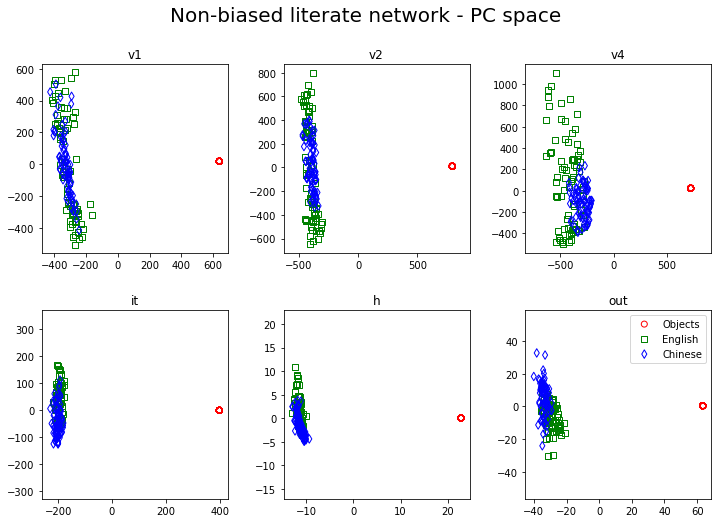

In [7]:
# PCA in python without any normalization or whiten matches PCA of MATLAB
from sklearn.decomposition import PCA
pcax = PCA(n_components=2)

fig, axs = plt.subplots(2,3, figsize=(12,8), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .3, wspace=.3)
axs = axs.ravel()

roi_ID = ['v1','v2','v4','it','h','out']
for idx in range(len(roi_ID)):
    
    out = pcax.fit_transform(nBli[roi_ID[idx]])
    axs[idx].scatter(out[qo, 0], out[qo, 1], marker='o',facecolors='none',edgecolor = 'r')
    axs[idx].scatter(out[qe, 0], out[qe, 1], marker= 's',facecolors='none',edgecolor = 'g')
    axs[idx].scatter(out[qc, 0], out[qc, 1], marker= 'd',facecolors='none',edgecolor = 'b')
    
    axs[idx].axis('equal');
    axs[idx].set_title(roi_ID[idx])
LEG = ['Objects', 'English', 'Chinese']

plt.legend((LEG[:]), bbox_to_anchor=(1, 1))
fig.suptitle('Non-biased literate network - PC space', fontsize=20)

    

In [ ]:
# 3D PCspace

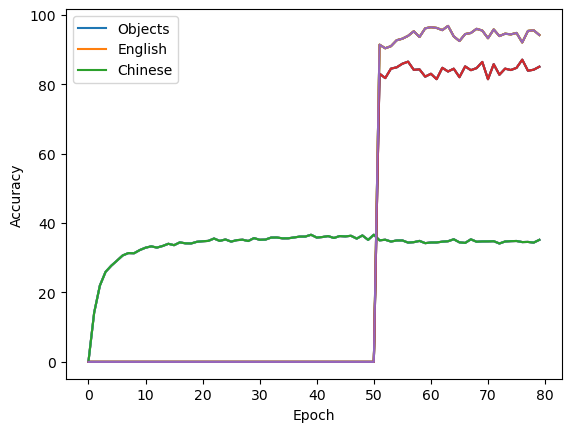

In [6]:
# Accuracy of the trained network
acc = np.load('models/cat_scores_lit_no_bias_z_full_nomir.npy')
np.shape(acc)
plt.plot(np.mean(acc[:,:1000],1))
plt.plot(np.mean(acc[:,1000:1500],1))
plt.plot(np.mean(acc[:,1500:],1))
plt.ylabel('Accuracy'); plt.xlabel('Epoch')
plt.legend(['Objects','English','Chinese'])
plt.show()